In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
import sys
import yaml
from sklearn.preprocessing import StandardScaler

sys.path.append("../")

In [2]:
from preprocessing.sliding_window import create_windowed_dataset
from preprocessing.skoda_preprocess import get_train_val_test
from model.hierarchical_self_attention_model import HSA_model_session_guided_window

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
skoda_file = '/home/hariub/data/HAR/raw/SkodaMiniCP_2015_08/right_classall_clean.mat'

data_dict = sio.loadmat(skoda_file, squeeze_me=True)
all_data = data_dict[list(data_dict.keys())[3]]

In [5]:
_x_train, _y_train, _x_test, _y_test, _x_val, _y_val = get_train_val_test(all_data)

In [6]:
print(_x_train.shape)
print(_y_train.shape)
print(_x_val.shape)
print(_y_val.shape)
print(_x_test.shape)
print(_y_test.shape)

(571774, 60)
(571774,)
(63535, 60)
(63535,)
(70595, 60)
(70595,)


In [7]:
import json
import os
activity_map = json.load(open(os.path.join('..','data', 'activity_maps', 'skoda_activity.json')))

In [8]:
activity_map

{'0': 'null',
 '1': 'write on notepad',
 '2': 'open hood',
 '3': 'close hood',
 '4': 'check gaps on the front door',
 '5': 'open left front door',
 '6': 'close left front door',
 '7': 'close both left door',
 '8': 'check trunk gaps',
 '9': 'open and close trunk',
 '10': 'check steering wheel'}

In [9]:
metadata = yaml.load(open('../configs/metadata.yaml', mode='r'), Loader=yaml.FullLoader)['skoda_preprocess']

SLIDING_WINDOW_LENGTH = metadata['sliding_win_len']
SLIDING_WINDOW_STEP = metadata['sliding_win_stride']
N_WINDOW, N_TIMESTEP = metadata['n_window'], metadata['n_timestep']

print('SLIDING_WINDOW_LENGTH :', SLIDING_WINDOW_LENGTH)
print('SLIDING_WINDOW_STEP :', SLIDING_WINDOW_STEP)
print('N_WINDOW :', N_WINDOW)
print('N_TIMESTEP :', N_TIMESTEP)

SLIDING_WINDOW_LENGTH : 715
SLIDING_WINDOW_STEP : 245
N_WINDOW : 13
N_TIMESTEP : 55


In [10]:
X_train, y_train = create_windowed_dataset(df=None, features=None, class_label=None, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP, X=_x_train, y=_y_train)
X_val, y_val = create_windowed_dataset(df=None, features=None, class_label=None, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP, X=_x_val, y=_y_val)
X_test, y_test = create_windowed_dataset(df=None, features=None, class_label=None, window_size=SLIDING_WINDOW_LENGTH, stride=SLIDING_WINDOW_STEP, X=_x_test, y=_y_test)

X_train = X_train.reshape(X_train.shape[0], N_WINDOW, N_TIMESTEP, _x_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], N_WINDOW, N_TIMESTEP, _x_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], N_WINDOW, N_TIMESTEP, _x_test.shape[1])

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

print(X_test.shape)
print(y_test.shape)

(2308, 13, 55, 60)
(2308, 11)
(233, 13, 55, 60)
(233, 11)
(261, 13, 55, 60)
(261, 11)


In [12]:
y_train_mid = np.repeat(np.expand_dims(y_train, axis=1), repeats=N_WINDOW, axis=1)
y_val_mid = np.repeat(np.expand_dims(y_val, axis=1), repeats=N_WINDOW, axis=1)
y_test_mid = np.repeat(np.expand_dims(y_test, axis=1), repeats=N_WINDOW, axis=1)

In [13]:
print(y_train_mid.shape)
print(y_val_mid.shape)
print(y_test_mid.shape)

(2308, 13, 11)
(233, 13, 11)
(261, 13, 11)


In [14]:
hparam_file = open('../configs/hyperparameters.yaml', mode='r')
hyperparameters = yaml.load(hparam_file, Loader=yaml.FullLoader)

hparams = hyperparameters['HSA_model']['skoda']
hparams['modality_indices'] = hyperparameters['HSA_model']['modality_indices']['skoda']
hparams['n_window'], hparams['n_timesteps'], hparams['n_features'], hparams['n_outputs'] = X_train.shape[1], X_train.shape[2], X_train.shape[3], y_train.shape[1]
hparams['n_outputs_window'] = len(activity_map)

In [15]:
hparams

{'modality_indices': [0,
  3,
  6,
  9,
  12,
  15,
  18,
  21,
  24,
  27,
  30,
  33,
  36,
  39,
  42,
  45,
  48,
  51,
  54,
  57],
 'dff': 256,
 'd_model': 64,
 'num_heads': 4,
 'dropout_rate': 0.2,
 'n_window': 13,
 'n_timesteps': 55,
 'n_features': 60,
 'n_outputs': 11,
 'n_outputs_window': 11}

In [16]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
device_list = ['/gpu:'+str(i) for i in range(0, 4)]
strategy = tf.distribute.MirroredStrategy(devices=device_list)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
with strategy.scope():
    model = HSA_model_session_guided_window(**hparams).get_compiled_model()

8 Physical GPUs, 8 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [17]:
checkpoint_filepath = "skoda_checkpoints/cp-{epoch:04d}.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=True,
                                                               verbose=1)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13, 55, 60)] 0                                            
__________________________________________________________________________________________________
multi_window_encoder (MultiWind ((None, None, 64), ( 1951680     input_1[0][0]                    
__________________________________________________________________________________________________
modality_encoder_block_19 (Moda (None, None, 64)     104000      multi_window_encoder[0][0]       
__________________________________________________________________________________________________
combined_sensor_self_attention_ ((None, 64), (None,  49856       modality_encoder_block_19[0][0]  
____________________________________________________________________________________________

In [26]:
model.fit(X_train, [y_train_mid, y_train], batch_size=len(device_list) * 64, epochs=2, validation_data=(X_val, [y_val_mid, y_val]), callbacks=[model_checkpoint_callback], use_multiprocessing=True)

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.1277 - session_pred_accuracy: 0.9567 - window_pred_accuracy: 0.9567 - session_pred_loss: 0.0646 - window_pred_loss: 0.0631
Epoch 00001: saving model to skoda_checkpoints/cp-0001.ckpt
10/10 [==============================] - 18s 2s/step - loss: 0.1277 - session_pred_accuracy: 0.9567 - window_pred_accuracy: 0.9567 - session_pred_loss: 0.0646 - window_pred_loss: 0.0631 - val_loss: 0.1039 - val_session_pred_accuracy: 0.9614 - val_window_pred_accuracy: 0.9637 - val_session_pred_loss: 0.0532 - val_window_pred_loss: 0.0508
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.1242 - session_pred_accuracy: 0.9593 - window_pred_accuracy: 0.9613 - session_pred_loss: 0.0642 - window_pred_loss: 0.0600
Epoch 00002: saving model to skoda_checkpoints/cp-0002.ckpt
10/10 [==============================] - 17s 2s/step - loss: 0.1242 - session_pred_accuracy: 0.9593 - window_pred_accuracy: 0.9613 - session_pred_loss: 0.064

In [29]:
# pred_mid, pred_sess = model.predict(X_test, batch_size=32)

model_from_ckpt = HSA_model_session_guided_window(**hparams).get_compiled_model()
model_from_ckpt.load_weights("skoda_checkpoints/cp-0040.ckpt")

In [34]:
pred_mid, pred_sess =model_from_ckpt.predict(X_test, batch_size=32)

## Session Level Result

In [35]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), labels=list(map(int, list(activity_map.keys()))), target_names=list(activity_map.values()), zero_division=1))

                              precision    recall  f1-score   support

                        null       1.00      1.00      1.00        65
            write on notepad       1.00      1.00      1.00        23
                   open hood       1.00      1.00      1.00        28
                  close hood       1.00      1.00      1.00        26
check gaps on the front door       1.00      1.00      1.00        18
        open left front door       0.50      1.00      0.67        10
       close left front door       1.00      0.00      0.00        10
        close both left door       1.00      1.00      1.00        20
            check trunk gaps       1.00      1.00      1.00        22
        open and close trunk       1.00      1.00      1.00        26
        check steering wheel       1.00      1.00      1.00        13

                    accuracy                           0.96       261
                   macro avg       0.95      0.91      0.88       261
                we

## Window Level Result

In [36]:
print(classification_report(np.argmax(y_test_mid.reshape(-1, len(activity_map)), axis=1), np.argmax(pred_mid.reshape(-1, len(activity_map)), axis=1), labels=list(map(int, list(activity_map.keys()))), target_names=list(activity_map.values()), zero_division=1))

                              precision    recall  f1-score   support

                        null       1.00      1.00      1.00       845
            write on notepad       1.00      1.00      1.00       299
                   open hood       1.00      1.00      1.00       364
                  close hood       1.00      1.00      1.00       338
check gaps on the front door       1.00      1.00      1.00       234
        open left front door       1.00      0.00      0.00       130
       close left front door       0.50      1.00      0.67       130
        close both left door       1.00      1.00      1.00       260
            check trunk gaps       1.00      1.00      1.00       286
        open and close trunk       1.00      1.00      1.00       338
        check steering wheel       1.00      1.00      1.00       169

                    accuracy                           0.96      3393
                   macro avg       0.95      0.91      0.88      3393
                we

<AxesSubplot:>

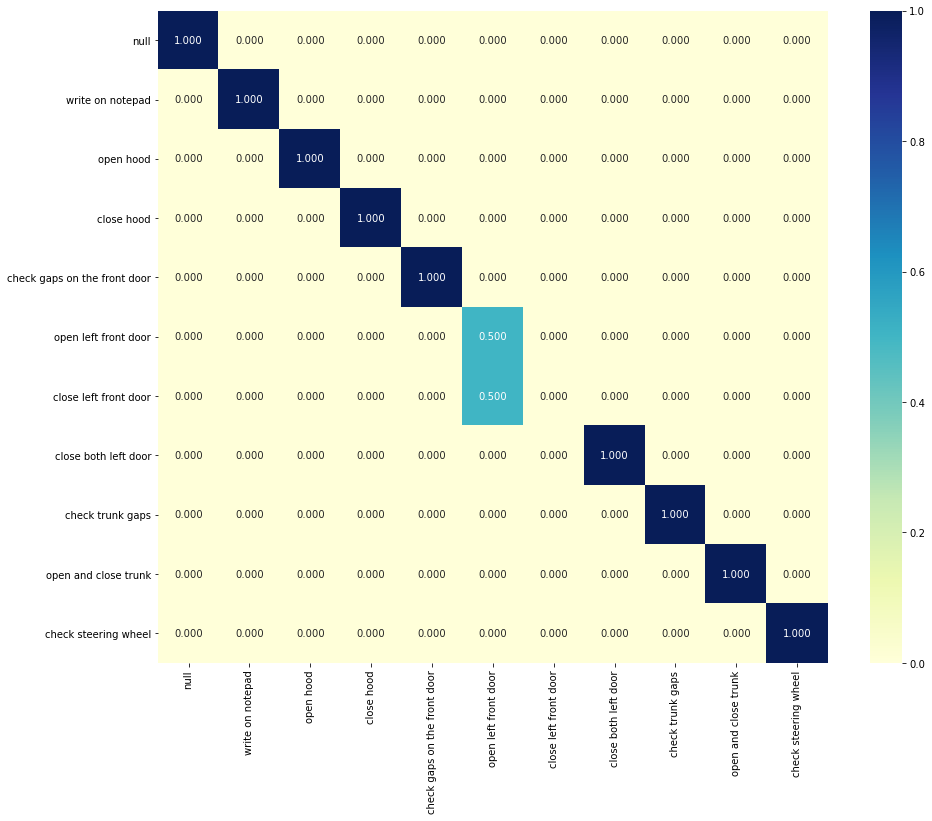

In [37]:
confm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_sess, axis=1), labels=list(map(int, list(activity_map.keys()))), normalize='pred')
activity_list = list(activity_map.values())
df_cm = pd.DataFrame(confm, index=activity_list, columns=activity_list)
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm, annot=True, fmt='0.3f', cmap="YlGnBu")